# Bechmark: Vern9 vs IRKGL16 (Float64) 

<ul id="top">
    <li><a href="#Loading-packages"> 
             Loading Packages</a></li>

<li><a href="#Initial-value-problem:-Burrau-problem">
             Initial value problem: Burrau problem</a></li>

<li><a href="#Integration-with-Vern9">
             Integration with Vern9</a></li>
             
<li><a href="#Integration-with-IRKGL16-(Adaptive-step)">
             Integration with IRKGL16 (Adaptive-step)</a></li>

<li><a href="#Error-in-energy">
             Error in energy</a></li> 

</ul>  


## Loading packages

In [1]:
using Pkg
using IRKGaussLegendre,LinearAlgebra,Plots,Statistics
using OrdinaryDiffEq
using BenchmarkTools,DiffEqDevTools

┌ Info: Precompiling IRKGaussLegendre [58bc7355-f626-4c51-96f2-1f8a038f95a2]
└ @ Base loading.jl:1273


In [2]:
BenchmarkTools.DEFAULT_PARAMETERS.samples=10

10

<a href="#top">Back to the top</a>

## Initial value problem: Burrau problem

The vector $Gm = (G\, m_1, \ldots, G\, m_N)$

In [3]:
include("../examples/InitialBurrau.jl")
u0, Gm =InitialBurrau()
N = length(Gm)
(size(u0), typeof(u0),typeof(Gm))

((2, 3, 3), Array{Float64,3}, Array{Int64,1})

Just to check that the output of the function NbodyODE has the expected type:

In [4]:
include("../examples/Nbody.jl")
du0=similar(u0)
NbodyODE!(du0,u0,Gm,0.)
@show size(du0);

size(du0) = (2, 3, 3)


In [5]:
t0 = 0.
T = 63. # Final time
dt = 10^(-4) # time-step length

tspan=(t0,T)
prob=ODEProblem(NbodyODE!,u0,tspan,Gm);

<a href="#top">Back to the top</a>


## Integration with Vern9

Recommend methods: Non-Stiff Problems

- For high accuracy non-stiff solving ( BigFloat and tolerances like <1e-12 ), JuliaDiffeq recommend
the Vern9 method


In [12]:
sol0 = @btime(solve(prob,Vern9(),abstol=1e-12,reltol=1e-12));

  188.307 ms (2143434 allocations: 233.46 MiB)


In [13]:
sol0.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  69826
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          3735
Number of rejected steps:                          629

## Integration with IRKGL16 (Adaptive-step)


In [6]:
(sol1,iters1,steps1)=@btime(solve(prob,IRKGL16(),
                            reltol=1e-12, abstol=1e-12,myoutputs=true));

  242.303 ms (2662486 allocations: 286.17 MiB)


In [7]:
mean(iters1)

10.0

In [8]:
sol1.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  87936
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          1073
Number of rejected steps:                          97

## Integration with IRKGL162 (Adaptive-step)

In [7]:
(sol2,iters2,steps2)=@btime(solve(prob,IRKGL162(),reltol=1e-12, abstol=1e-12,myoutputs=true));

  270.266 ms (2897355 allocations: 311.26 MiB)


In [8]:
mean(iters2)

11.891162790697674

In [9]:
sol2.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  95762
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          1074
Number of rejected steps:                          101

### Plots IRKGL16

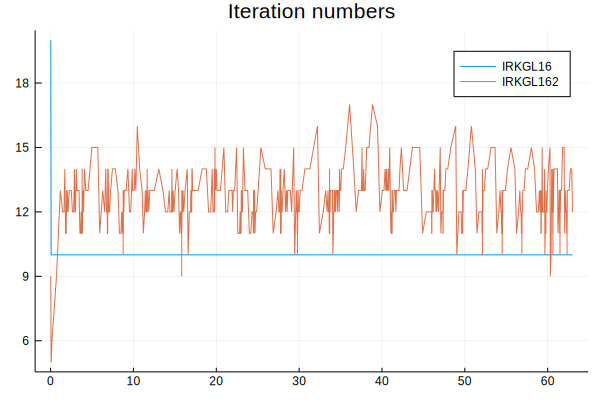

In [10]:
plot(sol1.t[2:end],iters1[2:end], title="Iteration numbers", label="IRKGL16")
plot!(sol2.t[2:end],iters2[2:end],label="IRKGL162")

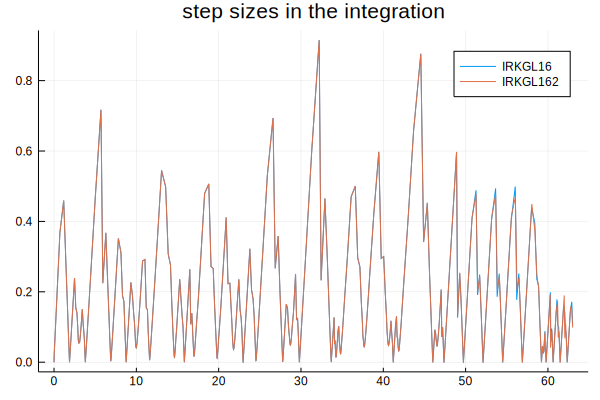

In [11]:
plot(sol1.t,steps1, title="step sizes in the integration", label="IRKGL16")
plot!(sol2.t,steps2,label="IRKGL162")

### Plots

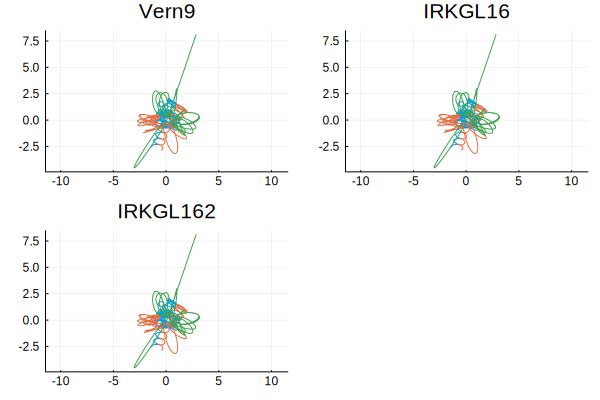

In [14]:
bodylist = ["Body-1", "Body-2", "Body-3"]
ulist0 = sol0.u
tlist0 = sol0.t

pl1 = plot(title="Vern9",aspect_ratio=1)

for j = 1:3
 xlist  = map(u->u[2,1,j], ulist0)
 ylist  = map(u->u[2,2,j], ulist0)
 pl1 = plot!(xlist,ylist, label="") # label = bodylist[j])   
end    


pl2 = plot(title="IRKGL16",aspect_ratio=1)

ulist1 = sol1.u[1:end]
tlist1 = sol1.t[1:end]

for j = 1:3
 xlist  = map(u->u[2,1,j], ulist1)
 ylist  = map(u->u[2,2,j], ulist1)
 pl2 = plot!(xlist,ylist,label="") # label = bodylist[j])   
end  


pl3 = plot(title="IRKGL162",aspect_ratio=1)

ulist2 = sol2.u[1:end]
tlist2 = sol2.t[1:end]

for j = 1:3
 xlist  = map(u->u[2,1,j], ulist2)
 ylist  = map(u->u[2,2,j], ulist2)
 pl3 = plot!(xlist,ylist,label="") # label = bodylist[j])   
end  

#plot(pl)
plot(pl1,pl2,pl3, layout=3)

In [18]:
plot(pl2)
savefig("Burrau.png")

<a href="#top">Back to the top</a>

## Error in energy

In [15]:
setprecision(BigFloat, 256)
u0128, Gm =InitialBurrau(BigFloat)
(typeof(u0128),typeof(Gm))

(Array{BigFloat,3}, Array{Int64,1})

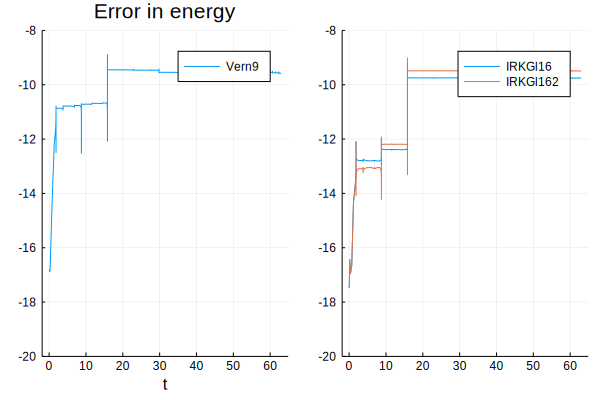

In [16]:
E0=NbodyEnergy(u0128,Gm)
end1=length(steps1)

ulist = sol0.u
tlist = sol0.t
EnergyErrors=[NbodyEnergy(BigFloat.(sol0.u[j]),Gm)/E0-1 for j in 1:length(tlist)]

ulist1 = sol1.u[1:end]
tlist1 = sol1.t[1:end]
EnergyErrors1=[NbodyEnergy(BigFloat.(sol1.u[j]),Gm)/E0-1 for j in 1:length(tlist1)]

ulist2 = sol2.u[1:end]
tlist2 = sol2.t[1:end]
EnergyErrors2=[NbodyEnergy(BigFloat.(sol2.u[j]),Gm)/E0-1 for j in 1:length(tlist2)]

ylimit1=-20
ylimit2=-8

p1=plot(tlist[1:end],log10.(abs.(EnergyErrors)),
    ylims=(ylimit1,ylimit2),
   xlabel="t", title="Error in energy", label="Vern9")
p2=plot(tlist1[1:end],log10.(abs.(EnergyErrors1)),
        ylims=(ylimit1,ylimit2),
        label="IRKGl16")
p2=plot!(tlist2[1:end],log10.(abs.(EnergyErrors2)),
        ylims=(ylimit1,ylimit2),
        label="IRKGl162")
plot(p1,p2,layout=2)

In [21]:
(Float32(maximum(abs.(EnergyErrors))),Float32(maximum(abs.(EnergyErrors1))),Float32(maximum(abs.(EnergyErrors2))))

(1.3100234f-9, 6.282468f-10, 1.012903f-9)

## Global errror

In [22]:
setprecision(BigFloat, 106)
u0128, Gm =InitialBurrau(BigFloat)
tspan128=(BigFloat(t0),BigFloat(T))
prob128=ODEProblem(NbodyODE!,u0128,tspan128,Gm);

In [23]:
sol = solve(prob128,Vern9(),save_everystep=false,abstol=1e-24,reltol=1e-24);
test_sol = TestSolution(sol);

In [24]:
ulist = sol.u
tlist = sol.t
DErrors=[NbodyEnergy(BigFloat.(sol.u[j]),Gm)/E0-1 for j in 1:length(tlist)]
DErrors[end]

4.11516181021079395457510196440589e-22

In [25]:
# Vern9
apr = appxtrue(sol0,test_sol)
#@show sol1[end]
#@show apr.u[end]
@show apr.errors

apr.errors = Dict(:l∞ => 114.491470653189127544133448204432,:L2 => 1.89746366326222307830887264608983,:final => 0.0152358554808226256365337357059989,:l2 => 4.72630097951935465897272036730624,:L∞ => 11.8661723457866025853302951869405)


Dict{Symbol,BigFloat} with 5 entries:
  :l∞    => 114.491
  :L2    => 1.89746
  :final => 0.0152359
  :l2    => 4.7263
  :L∞    => 11.8662

In [26]:
# IRGL16
apr = appxtrue(sol1,test_sol)
#@show sol1[end]
#@show apr.u[end]
@show apr.errors

apr.errors = Dict(:l∞ => 113.838528799420388102056908603246,:L2 => 1.89963778701834853934157279746061,:final => 0.00692361442013512323964232897034783,:l2 => 5.01285395557142505656311984374341,:L∞ => 11.8661857527977962930698928141054)


Dict{Symbol,BigFloat} with 5 entries:
  :l∞    => 113.839
  :L2    => 1.89964
  :final => 0.00692361
  :l2    => 5.01285
  :L∞    => 11.8662

In [27]:
# IRGL162
apr = appxtrue(sol2,test_sol)
#@show sol1[end]
#@show apr.u[end]
@show apr.errors

apr.errors = Dict(:l∞ => 113.838528283804094025858352095856,:L2 => 1.89846606188475070302949148150995,:final => 0.0128462703034132918735656310394278,:l2 => 5.0128532625593959463793344210383,:L∞ => 11.8660365343460520889529439920579)


Dict{Symbol,BigFloat} with 5 entries:
  :l∞    => 113.839
  :L2    => 1.89847
  :final => 0.0128463
  :l2    => 5.01285
  :L∞    => 11.866

In [28]:
err0=Float32(norm(sol0.u[end]-sol.u[end]))
err1=Float32(norm(sol1.u[end]-sol.u[end]))
err2=Float32(norm(sol2.u[end]-sol.u[end]))
(err0,err1,err2)

(0.11974903f0, 0.054328073f0, 0.1009194f0)